**Load python libraries**

In [10]:
%matplotlib inline
import boto3
import botocore
import datetime
import matplotlib.pyplot as plt
import os.path
import xarray as xr
import numpy as np
import requests
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from IPython.display import Image, display
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import pandas as pd

from modules.GOESR_functions import goes_lat_lon_reproj, get_s3_keys
from modules.plotter import loadCPT

**Set up access to S3 bucket using `boto3` and a low-level client**

Rather than setting up access key and ID, we will use a low-level client to request data anonymously.

In [2]:
# No AWS keys required
client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED))

Let's check out what is in the NOAA GOES AWS bucket. For more information on each of the products, see this [documentation](https://docs.opendata.aws/noaa-goes16/cics-readme.html). 

In [3]:
# bucket_name = 'noaa-goes16'
bucket_name = 'noaa-goes17'

paginator = client.get_paginator('list_objects')
result = paginator.paginate(Bucket=bucket_name, Delimiter='/')
for prefix in result.search('CommonPrefixes'):
    print(prefix.get('Prefix'))

ABI-L1b-RadC/
ABI-L1b-RadF/
ABI-L1b-RadM/
ABI-L2-ACHAC/
ABI-L2-ACHAF/
ABI-L2-ACHAM/
ABI-L2-ACHTF/
ABI-L2-ACHTM/
ABI-L2-ACMC/
ABI-L2-ACMF/
ABI-L2-ACMM/
ABI-L2-ACTPC/
ABI-L2-ACTPF/
ABI-L2-ACTPM/
ABI-L2-ADPC/
ABI-L2-ADPF/
ABI-L2-ADPM/
ABI-L2-AODC/
ABI-L2-AODF/
ABI-L2-CMIPC/
ABI-L2-CMIPF/
ABI-L2-CMIPM/
ABI-L2-CODC/
ABI-L2-CODF/
ABI-L2-CPSC/
ABI-L2-CPSF/
ABI-L2-CPSM/
ABI-L2-CTPC/
ABI-L2-CTPF/
ABI-L2-DMWC/
ABI-L2-DMWF/
ABI-L2-DMWM/
ABI-L2-DSIC/
ABI-L2-DSIF/
ABI-L2-DSIM/
ABI-L2-DSRC/
ABI-L2-DSRF/
ABI-L2-DSRM/
ABI-L2-FDCC/
ABI-L2-FDCF/
ABI-L2-LSTC/
ABI-L2-LSTF/
ABI-L2-LSTM/
ABI-L2-LVMPC/
ABI-L2-LVMPF/
ABI-L2-LVMPM/
ABI-L2-LVTPC/
ABI-L2-LVTPF/
ABI-L2-LVTPM/
ABI-L2-MCMIPC/
ABI-L2-MCMIPF/
ABI-L2-MCMIPM/
ABI-L2-RRQPEF/
ABI-L2-RSRC/
ABI-L2-RSRF/
ABI-L2-SSTF/
ABI-L2-TPWC/
ABI-L2-TPWF/
ABI-L2-TPWM/
ABI-L2-VAAF/
GLM-L2-LCFA/
SUVI-L1b-Fe093/
SUVI-L1b-Fe13/
SUVI-L1b-Fe131/
SUVI-L1b-Fe17/
SUVI-L1b-Fe171/
SUVI-L1b-Fe195/
SUVI-L1b-Fe284/
SUVI-L1b-He303/


In [4]:
product_name = 'ABI-L2-CMIPC'
year = 2019
day_of_year = 65
hour = 4
band = 13

prefix = product_name + '/' + str(year) + '/' + str(day_of_year).zfill(3)  \
+ '/' + str(hour).zfill(2) + '/OR_'+ product_name + '-M3C' + str(band).zfill(2)
prefix

'ABI-L2-CMIPC/2019/065/04/OR_ABI-L2-CMIPC-M3C13'

In [5]:
time_idx = 4
keys = get_s3_keys(bucket_name, prefix = prefix)
s3_data_key = [key for key in keys][time_idx] ## specific time between 0 and 11
# s3_data_key = [key for key in keys][0] # selecting the first measurement taken within the hour

**Download netcdf for specified key**

In [6]:
resp = requests.get('https://' + bucket_name + '.s3.amazonaws.com/' + s3_data_key)

In [7]:
file_name = s3_data_key.split('/')[-1].split('.')[0]
nc4_ds = netCDF4.Dataset(file_name, memory = resp.content)
store = xr.backends.NetCDF4DataStore(nc4_ds)
DS = xr.open_dataset(store)
ds_cmi = DS.CMI.load()

**Convert radiance scan x, y data into derived latitude and longitude values using [this tutorial](https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm).**

In [8]:
lats, lons = goes_lat_lon_reproj(DS)
# print test coordinates
print('{} N, {} W'.format(lats[318,1849],abs(lons[318,1849])))

40.94820022583008 N, 121.76856231689453 W


**Import NOAA NEXRAD L3 Hail Signatures**

In [11]:
## NOAA SWDI Hail Locations 6 March 2019 ##

## location and name of txt file
filename = '../data/NOAA_SWDI/swdiws_nx3hail_all_20190306_bbox_-131_31_-116_41.csv'
# filename = '../data/NOAA_SWDI/noaa_swdi_hail_030602019_retrieved03102020.csv'
df = pd.read_csv(filename, header=0, parse_dates=['ZTIME'], skipfooter=3, engine='python')
df = df.replace(-999, np.NaN)
x_hail = df.LON
y_hail = df.LAT
df['MAXSIZE'] = df['MAXSIZE']*25.4 ## convert from inches to mm
# df

print('Average hail size:', df.MAXSIZE.mean(), 'mm')
print('Max hail size:', df.MAXSIZE.max(), 'mm')

Average hail size: 13.548815566836103 mm
Max hail size: 44.449999999999996 mm


In [18]:
DS.time_coverage_start

'2019-03-06T04:22:18.9Z'

In [23]:
#greater than the start date and smaller than the end date & In Cloud
time_mask = (df['ZTIME'] > '2019-03-06 04:15') & (df['ZTIME'] <= '2019-03-06 04:45')

hail_df = df.loc[time_mask]
hail_df

,ZTIME,WSR_ID,CELL_ID,PROB,SEVPROB,MAXSIZE,LAT,LON
367,2019-03-06 04:16:33+00:00,KHNX,L1,NaN,NaN,NaN,34.026,-120.215
368,2019-03-06 04:16:33+00:00,KHNX,A3,10.0,0.0,12.7,34.654,-119.421
369,2019-03-06 04:16:33+00:00,KHNX,E0,80.0,30.0,12.7,34.956,-119.128
370,2019-03-06 04:16:33+00:00,KMUX,V0,NaN,NaN,NaN,35.217,-120.946
371,2019-03-06 04:16:47+00:00,KVBX,F8,60.0,30.0,12.7,33.845,-121.503
372,2019-03-06 04:16:47+00:00,KVBX,G3,80.0,20.0,12.7,34.071,-120.202
373,2019-03-06 04:16:47+00:00,KVBX,W2,60.0,0.0,12.7,34.962,-119.110
374,2019-03-06 04:16:53+00:00,KSOX,R2,NaN,NaN,NaN,34.016,-120.209
375,2019-03-06 04:16:53+00:00,KSOX,N2,50.0,0.0,12.7,34.959,-119.134
376,2019-03-06 04:17:51+00:00,KVTX,I9,10.0,0.0,12.7,33.541,-118.213


**Plot using cartopy**

./figures/fS6.png


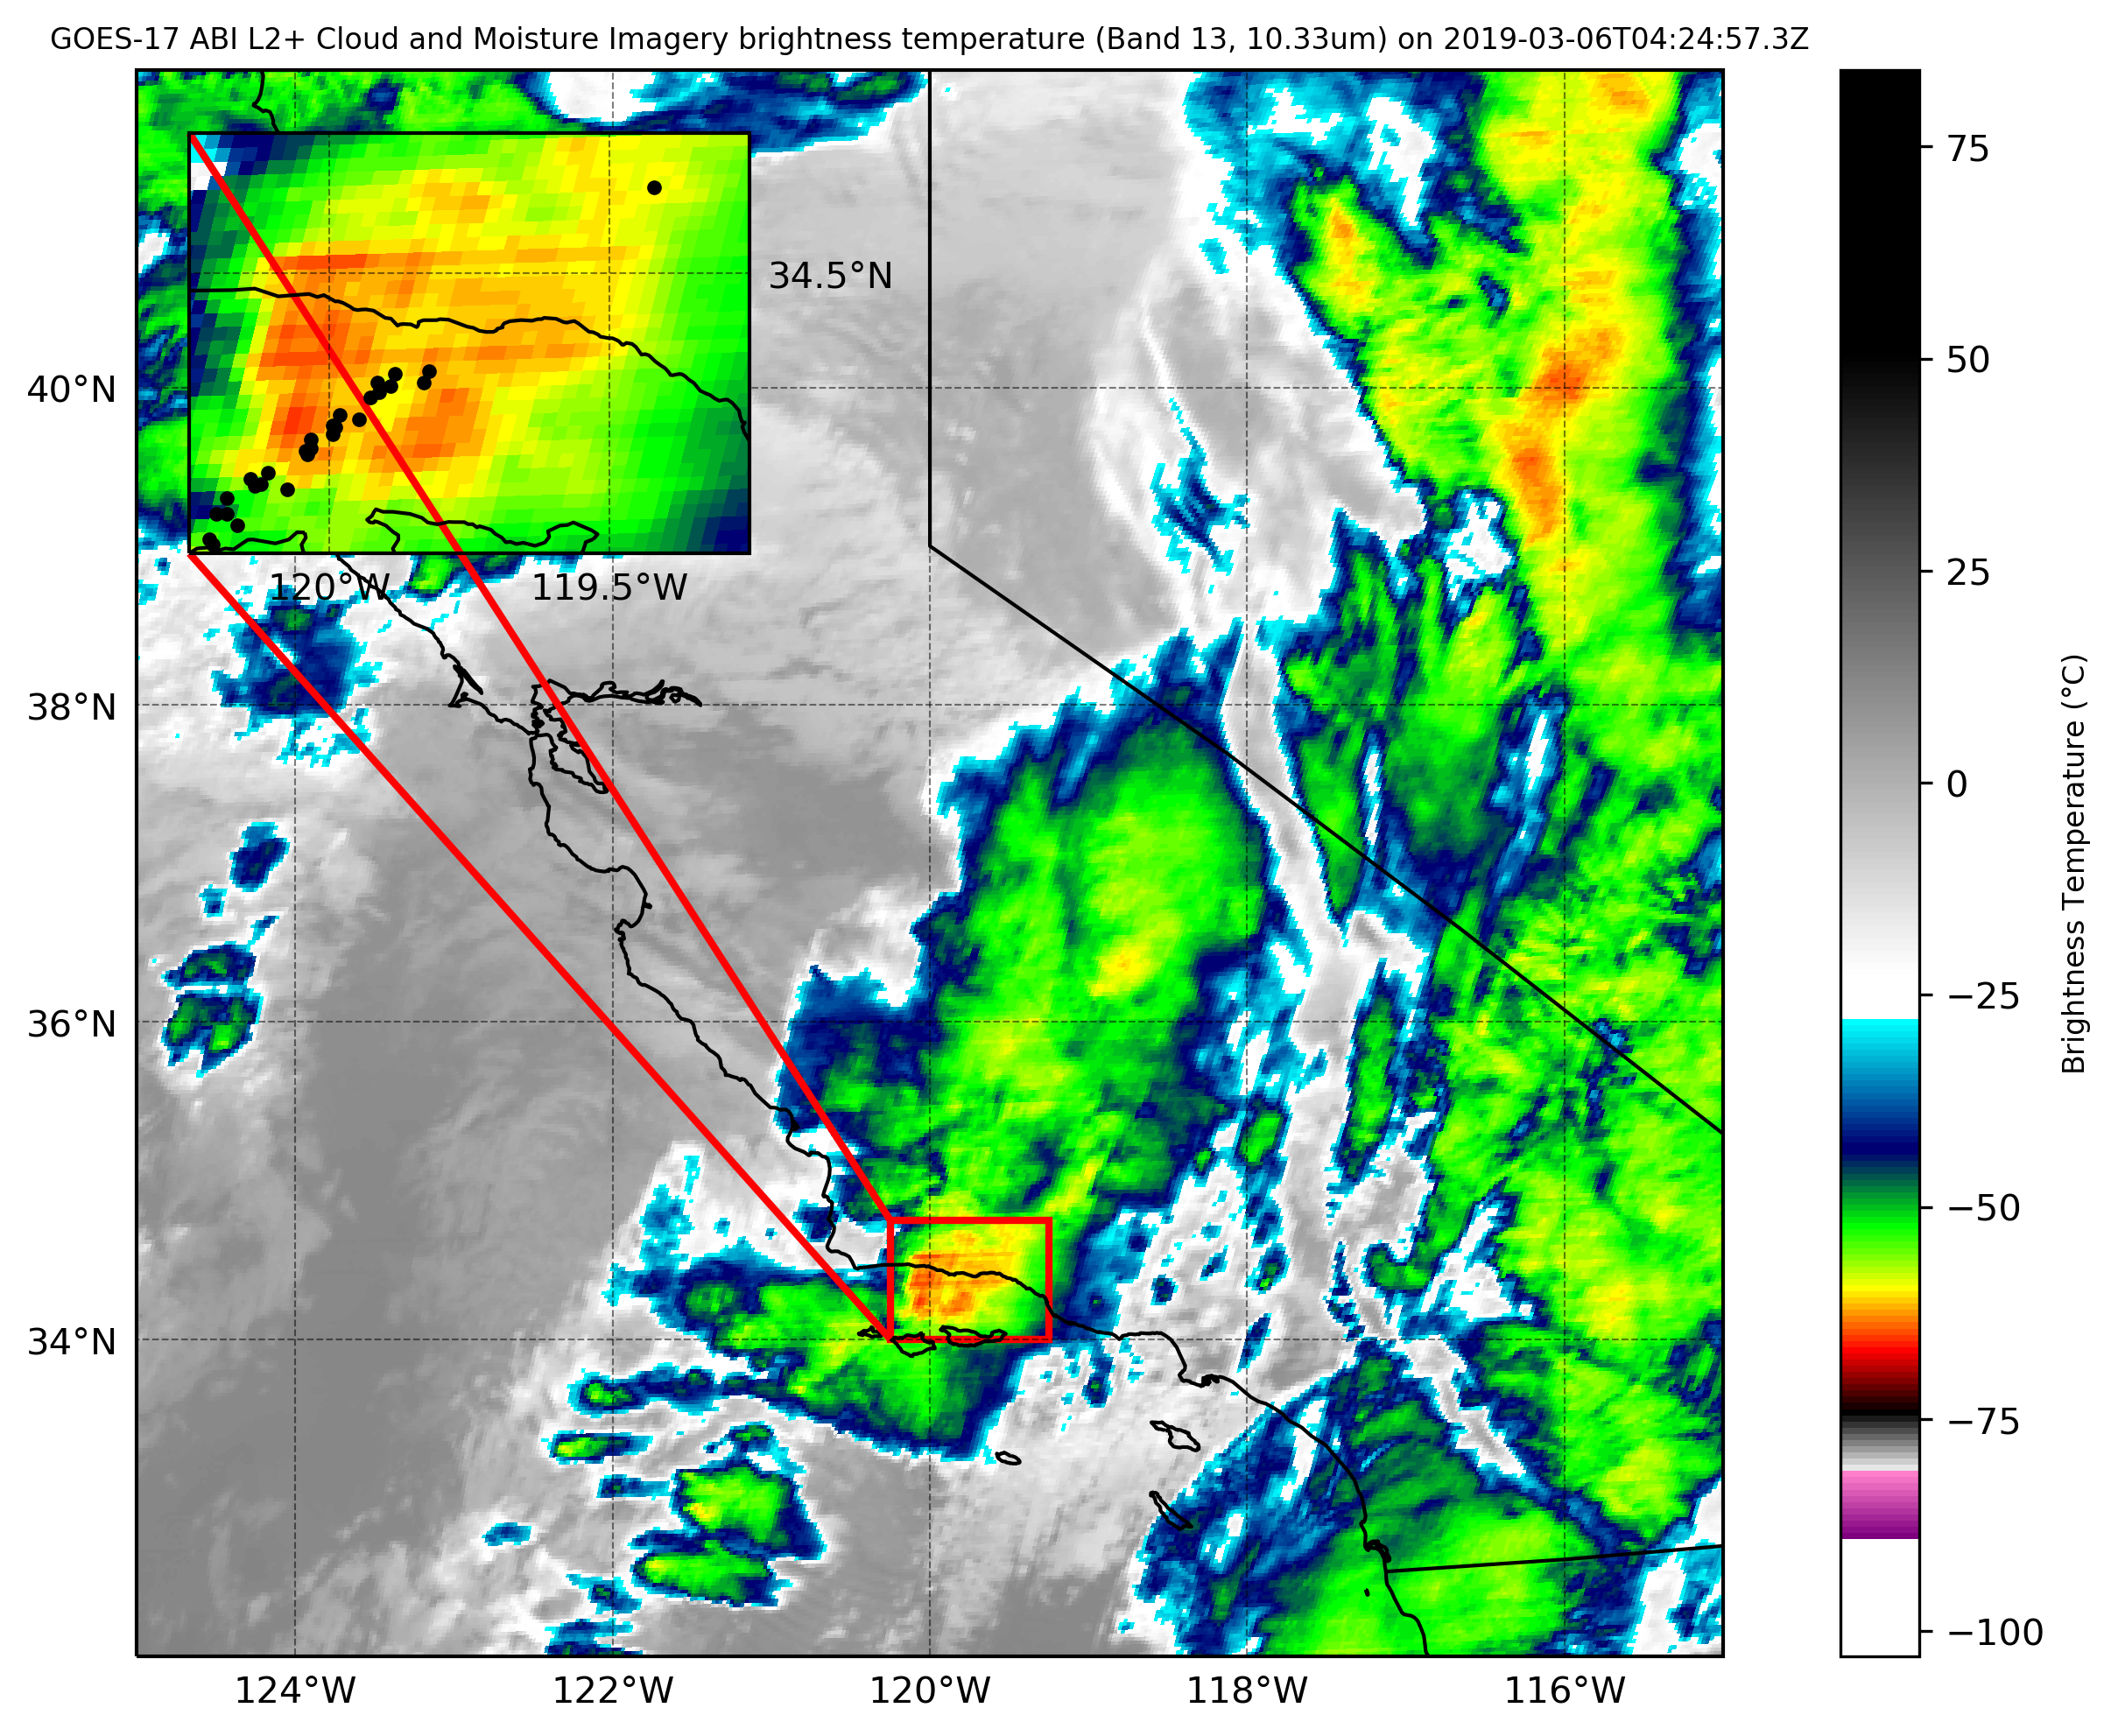

<Figure size 3450x2400 with 0 Axes>

In [25]:
# Converts a CPT file to be used in Python
cpt = loadCPT('../data/Colortables/IR4AVHRR6.cpt')

fig = plt.figure(figsize=(11.5,8))
fig.dpi = 300
fname = './figures/fS6'
file_name
fmt1 = 'png'
fmt2 = 'pdf'

results = ds_cmi - 273.15 ## Convert to Celsius
ext = [-115.0, -125.0, 32.0, 42.0]

datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

ax = plt.axes(projection=mapcrs)
ax.set_extent(ext, crs=mapcrs)

cm = ax.pcolormesh(lons.data, lats.data, results, transform=datacrs, cmap=cpt, vmin=-103, vmax=84)
gl = ax.gridlines(crs=datacrs, draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator(np.arange(-126., -112., 2))
gl.ylocator = mticker.FixedLocator(np.arange(30, 44, 2))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
# Add Border Features
coast = ax.coastlines(linewidths=1.0, resolution='10m')
ax.add_feature(states_provinces, edgecolor='k')
ax.add_feature(cfeature.BORDERS)

band_info = '(Band ' + str(DS.band_id.values[0]) + ', ' \
+ str(DS.band_wavelength.values[0]) + DS.band_wavelength.units + ')'
plt.title('GOES-17 {0} {1} on {2}'.format(DS.CMI.long_name, band_info, DS.time_coverage_end), 
          fontsize=8)

# Add a color bar
cbar = plt.colorbar(cm, orientation='vertical')

Unit = "Brightness Temperature ($\mathrm{\degree C}$)"
cbar.set_label(Unit, fontsize=8)

### Add inset map
ext2 = [-119.25, -120.25, 34.0, 34.75]
axins = plt.axes([0.23, 0.65, 0.2, 0.2], projection=mapcrs)
axins.set_extent(ext2, crs=mapcrs)

cm2 = axins.pcolormesh(lons.data, lats.data, results, transform=datacrs, cmap=cpt, vmin=-103, vmax=84)
gl = axins.gridlines(crs=datacrs, draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator(np.arange(-120.5, -118.5, 0.5))
gl.ylocator = mticker.FixedLocator(np.arange(34, 35.5, 0.5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = True
gl.ylabels_left = False
# Add Border Features
coast = axins.coastlines(linewidths=1.0, resolution='10m')

## Add hail points
point = axins.plot(hail_df.LON, hail_df.LAT, marker='o', 
                color='k', markersize=3,
                linestyle='None',
                transform=datacrs)
    
# mark_inset marks the bounding box of the inset map
mark_inset(ax, axins, loc1=3, loc2=2, fc="none", lw=2, ec='r')

fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
# fig.savefig('%s.%s' %(fname, fmt2), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))